In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_mldata

#### 读取数据集
    
__注意：__ 当使用 __fetch_mldata__ 读取数据时，要将数据集放在 __mldata__ 目录下。

In [2]:
mnist = fetch_mldata('MNIST original',data_home='./')
mnist
X,y = mnist['data'],mnist['target']

D:\python\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
D:\python\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
X.shape

(70000, 784)

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

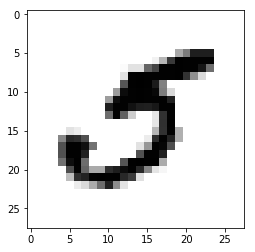

In [5]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation='nearest')

In [6]:
y[36000]

5.0

In [7]:
x_train,x_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

因为有的算法可能会受到训练样例的顺序的影响，当在一行中得到许多相似的样例，算法的效果会很差，所以随机打乱

In [8]:
shuffle_index = np.random.permutation(60000)
x_train,y_train = x_train[shuffle_index],y_train[shuffle_index]

In [9]:
x_train.shape

(60000, 784)

In [10]:
y_train.shape

(60000,)

#### 训练一个二分类器

现在我们简化一下问题，只尝试去识别一个数字，比如说，数字	5。这个“数字	5	检测器”就是 一个二分类器，能够识别两类别，“是	5”和“非	5”。让我们为这个分类任务创建目标向量：


In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
y_train_5

array([False, False, False, ..., False, False,  True])

使用 __随机梯度下降分类器 SGD__ 来训练它。

这个分类器有一个好处是能够高效地处理非常大的数据集。这部分原因在于 __SGD__ 一次只处理一条数据，这也使得 __SGD__ 适合在线学习。

__SGDClassifier__	依赖于训练集的随机程度（所以被命名为	stochastic，随机之义）。如果你想重现结果，你应该固定参数 __random_state__。

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
display(sgd_clf.predict([X[36000]]))
y[36000]

array([False])

5.0

识别成功

#### 对性能的评估
    
对性能评估最好的方法还是使用 __交叉验证__ 。

接下来还是使用交叉验证对训练模型进行评估。

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

__实现一个自己版本的交叉验证__

以下代码粗略地做了和	cross_val_score()	相同的事情，并且输出相同的结果。


In [17]:
skfold = StratifiedKFold(n_splits=3,random_state=42)

for train_index,test_index in skfold.split(x_train,y_train_5):
    sgd_clf_clone = clone(sgd_clf)
    
    x_train_fold = x_train[train_index]
    x_test_fold = x_train[test_index]
    
    y_train_5_fold = y_train_5[train_index]
    y_test_5_fold = y_train_5[test_index]
    
    sgd_clf_clone.fit(x_train_fold,y_train_5_fold)
    y_pred = sgd_clf_clone.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_5_fold)
    print(n_correct/len(y_pred))

0.96295
0.96015
0.95895


使用 cross_val_score() 函数来评估 SGDClassifier 模型

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
cross_val_score(sgd_clf,x_train,y_train_5,cv=3,scoring='accuracy')

array([0.96295, 0.96015, 0.95895])

看起来分类效果好像很好，但是先别高兴，现在我们使用一个非常笨的分类器去分类，看看非5这个类上的表现。

#### 自定义一个估计器

需要继承 __BaseEstimator__ 。

因为 __BaseEstimator__ 中有 __get_params__ 和 __set_params__ 这两种方法，在下面的交叉验证中需要用到这两种方法。

In [20]:
BaseEstimator??

Object `BaseEstimator` not found.


In [21]:
from sklearn.base import BaseEstimator

In [22]:
class Never5classifier(BaseEstimator):
    def fit(self,x,y=None):
        pass
    def predict(self,x):
        return np.zeros((len(x),1),dtype=bool)

In [24]:
# never_5_clf.get_params

In [26]:
sgd_clf.get_params

<bound method BaseEstimator.get_params of SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)>

需要继承 __BaseEstimator__ 才可以在交叉验证中使用 __Never5classifier__ 这个自定义的函数。

In [27]:
never_5_clf = Never5classifier() 
cross_val_score(never_5_clf,x_train,y_train_5,scoring='accuracy')

D:\python\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.90875, 0.9086 , 0.9116 ])

可以看到即使预测结果全为False，那么准确率也高达90%。

这证明了精度不是一个很好的性能度量指标，接下来看 __混淆矩阵__

__cross_val_predict()__	也使用	K 折交叉验证。它不是返回一个评估分数，而是返回基于每一个测试折做出的一个预测值。这意味着，对于每一个训练集的样例，你得到一个干净的预测（“干净”是说一个模型在训练过程当中没有用到测试集的数据）

In [28]:
from sklearn.model_selection import cross_val_predict

In [29]:
y_train_pred = cross_val_predict(sgd_clf,x_train,y_train_5,cv=3)

In [30]:
y_train_pred

array([False, False, False, ..., False, False, False])

### 混淆矩阵

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
confusion_matrix(y_train_5,y_train_pred)

array([[53436,  1143],
       [ 1216,  4205]], dtype=int64)

混淆矩阵中的每一行表示一个实际的类,	而每一列表示一个预测的类。

该矩阵的第一行认为“非 5”（反例）中的	53272	张被正确归类为	“非	5”（他们被称为真反例,true negatives）,	而其余 1099 被错误归类为 "是5"	（假正例，false	positives）。第二行认为“是	5”	（正例）中的	1838 被错误地归类为 “非5”（假反例，false	negatives），其余	3583	正确分类为	“是5”类（真正例，true	positives）

### 准确率和召回率的折衷

在 __SGD__ 中来划分一个图片是不是某个数值，依靠的是 __阈值__。

__Scikit-Learn__ 不让你直接设置阈值，但是它给你提供了设置决策分数的方法，这个决策分数可 以用来产生预测。

它不是调用分类器的	predict() 方法，而是调用 __decision_function()__ 方法。

__这个方法返回每一个样例的分数值，然后基于这个分数值，使用你想要的任何阈值做出预测。__


In [33]:
# 通过 decision_function 来计算some_digit这个图片的决策分数。
y_score = sgd_clf.decision_function([some_digit])
y_score

array([-250.72815124])

__根据决策分数和阈值进行对比，如果决策分数大于阈值，则视为正类，反之视为负类。__

In [34]:
threshold = 0
y_some_digit_pre = (y_score >threshold)
y_some_digit_pre

array([False])

In [35]:
threshold = 4000
y_some_digit_pre = (y_score >threshold)
y_some_digit_pre

array([False])

__这证明了提高阈值会降调召回率__

__那么，你应该如何使用哪个阈值呢？__

首先，你需要再次使用	__cross_val_predict()__	得到每一个样例的分数值，但是这一次指定返回一个 __决策分数__ ，而不是预测值。

__decision_function__ 方法返回每个实例的分数，然后就可以根据这些分数，使用任意阈值进行预测。

In [36]:
y_score = cross_val_predict(sgd_clf,x_train,y_train_5,cv=3,method='decision_function')
y_score

array([ -9928.63021355,  -3695.48763914, -28946.54304815, ...,
        -8922.13609188, -15296.98970408,  -2215.7998451 ])

现在有了这些分数值。对于任何可能的阈值，使用 __precision_recall_curve()__ (计算不同概率阈值的精确召回对) 。

可以用于计算 __准确率__ 和 __召回率__

In [37]:
from sklearn.metrics import precision_recall_curve

__注意：__ 得到的 __threshold__ 的shape和 __precision__ 和 __recall__ 的shape都不一样，所以在绘制图像的使用要加上 __[0:-1]__,会截取到最后一个数(但是不包含)。

__因为绘制时x和y的shape要相同。__

In [38]:
precision,recall,threshold = precision_recall_curve(y_train_5,y_score)

In [39]:
print('precision[:-1].shape: ',precision[:-1].shape)
print('precision.shape: ',precision.shape)
print('threshold.shape: ',threshold.shape)

precision[:-1].shape:  (59986,)
precision.shape:  (59987,)
threshold.shape:  (59986,)


#### 绘制精确率和召回率的曲线
    
__准确率__ 不一定随着 __阈值__ 的增加而上升，但是 __召回率__ 一定会随着 __阈值__ 的增加而上升。

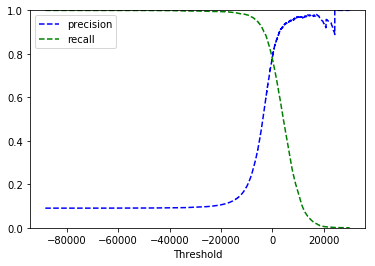

In [40]:
def precision_recall_vs_threshold(precision,recall,threshold):
    plt.plot(threshold,precision[:-1],'b--',label='precision')
    plt.plot(threshold,recall[:-1],'g--',label='recall')
    plt.legend(loc='upper left')
    plt.xlabel('Threshold')
    plt.ylim(0,1)

precision_recall_vs_threshold(precision,recall,threshold)
plt.show()

In [41]:
from sklearn.metrics import recall_score,precision_score

检验在 __准确度为90%时__，阈值的大小。

In [42]:
y_train_pred_90 = (y_score > 20000)
display(precision_score(y_train_5,y_train_pred_90))
recall_score(y_train_5,y_train_pred_90)

0.9375

0.005534034311012728

#### PR曲线

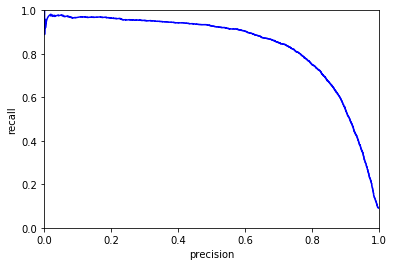

In [43]:
def plot_pr(precision,recall):
    plt.plot(recall,precision,'b')
    plt.axis([0,1,0,1])
    plt.xlabel('precision')
    plt.ylabel('recall')    

plot_pr(precision,recall)

#### ROC曲线

为了画出 __ROC 曲线__ ，你首先需要计算各种不同阈值下的 __TPR__、 __FPR__ 使用 __roc_curve()__ 函数 。

In [44]:
from sklearn.metrics import roc_curve

In [45]:
fpr,tpr,threshold = roc_curve(y_train_5,y_score)

#### 这里同样存在折衷的问题：

__召回率（TPR）越高__ ，分类器就会 __产生越多的假正例（FPR）__ 。 

图中的点线是一个完全随机的分类器生成的 ROC 曲线； __一个好的分类器的 ROC 曲线应该尽可能远离这条线（即向左上角方向靠拢）__

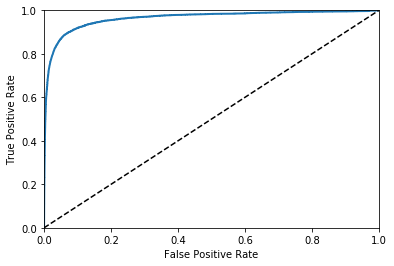

In [46]:
def plt_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    # 绘制副对角线
    plt.plot([0,1],[0,1],'k--')
    # 设置图像坐标
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')            
plt_roc_curve(fpr,tpr)

#### 一个比较分类器之间优劣的方法是：

测量ROC曲线下的面积（AUC）。 __一个完美的分类器的 ROC	AUC	等于 1，而一个纯随机分类器的	ROC	AUC	等于 0.5。__

Scikit-Learn 提供了一个函数来计算	ROC	AUC： __roc_auc_score__。 即计算AUC的面积。

In [47]:
from sklearn.metrics import roc_auc_score

In [48]:
roc_auc_score(y_train_5,y_score)

0.9638788138653887

#### 训练一个新的分类器随机森林，用于和SGD比较ROC AUC曲线

但是随机森林分类中不支持使用 __dicision_function__ 所以这里将使用另外一种方法 __predict_proba()__ 方法。

__predict_proba()__ 方法将返回一个数组，数组中的 __每一行表示一个样例__ ， __每一列代表一个类__ 。

__数组当中的值的意思是：__ 给一个样例属于给定样例的概率，比如这幅图70%的概率为5。

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,x_train,y_train_5,cv=3,method='predict_proba')

D:\python\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\python\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\python\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


__对于二分类任务，第一列表示0(负类)的概率，第二列表示1(正类)的概率。__

predict_proba返回的是一个n行k列的数组，第i行第j列上的数值是模型预测第i个预测样本的标签为j的概率。所以每一行的和应该等于1.

In [51]:
y_probas_forest

array([[1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.9, 0.1]])

因为绘制ROC曲线需要样例的分数值，而不是概率， __一个简单的方法就是使用正例的概率来作为分数。__

In [54]:
y_scores_forest = y_probas_forest[:,1] # 正类的概率
forest_fpr,forest_tpr,forest_threshold = roc_curve(y_train_5,y_scores_forest)

#### 绘制SGD和Random Forest的 ROC 曲线

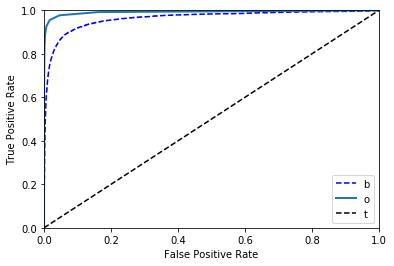

In [53]:
plt.plot(fpr,tpr,'b--',label='SGD')
plt_roc_curve(forest_fpr,forest_tpr,label='Random Forest')
plt.legend('bottom right')
plt.show()

#### 计算 Random Forest 的 ROC AUC 面积

In [159]:
roc_auc_score(y_train_5,y_scores_forest)

0.9922934473328788

## 多分类

多分类中分 __(OvA) “一对所有”__  和 __(OvO) “一对一” __ 模式。

__创建一个可以将图片分成	10	类（从	0 到	9）的系统的一个方法是：__ 训练10个二分类 器，每一个对应一个数字（探测器 0，探测器 1，探测器 2，以此类推）。然后当你想对某张图片进行分类的时候，让每一个分类器对这个图片进行分类，选出决策分数最高的那个分类器。这叫做 __“一对所有”（OvA）策略__ （也被叫做“一对其他”）。 

__另一个策略是：__ 对每一对数字都训练一个二分类器：一个分类器用来处理数字	0	和数字	1，一 个用来处理数字	0	和数字	2，一个用来处理数字	1	和	2，以此类推。这叫做 __“一对一”（OvO） 策略__ 。

__Scikit-Learn__	可以探测出你想使用一个二分类器去完成多分类的任务，它会 __自动地执行 OvA__ (除了 SVM 分类器，它使用	OvO)

In [161]:
sgd_clf = SGDClassifier()
sgd_clf.fit(x_train,y_train)

In [163]:
sgd_clf.predict([X[36000]])

array([5.])


在幕后， __Scikit-Learn__	实际上训练了 10 个二分类器，每个分类器都产到一张图片的 __决策数值__ ，选择数值 __最高__ 的那个类。

为了证明这是真实的，你可以调用	__decision_function()__	方法。不是返回每个样例的一个数值，而是返回 10 个数值，一个数值对应于一个类。


In [165]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-16927.36851239, -23849.28787104,  -3883.98567825,
        -12302.73638661,  -6560.08565065,   -843.60696665,
        -10976.96561307, -15262.12474773,   -516.55618285,
          3239.66234082]])

In [168]:
np.argmax(some_digit_scores)

9

__一个分类器被训练好了之后，它会保存目标类别列表到它的属性 classes\_ 中去，按照值排序。__

在本例子当中，在 classes_ 数组当中的每个类的索引方便地匹配了类本身，比 如，索引为	9	的类恰好是类别	9	本身。 __但通常不会这么幸运__。


In [169]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [170]:
sgd_clf.classes_[9]

9.0

__如果你想强制	Scikit-Learn	使用	OvO	策略或者	OvA	策略__ ，你可以使用	__OneVsOneClassifier__	类 或者	__OneVsRestClassifier__	类。

创建一个样例，传递一个二分类器给它的构造函数。

In [172]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

len(ovo_clf.estimators_) # 查看有生成了多少个估计器。

### 误差分析

假设你已经找到一个不错的模型，你试图找到方法去改善它。一个方式是 __分析模型产生的误差的类型__ 。

首先你可以检查混淆矩阵。第一步仍然是使用 __cross_val_predict() 函数__ 生成预测值。然后调用 __confusion_matrix() 函数__。

In [173]:
y_train_pre = cross_val_predict(sgd_clf,x_train,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pre)

In [184]:
conf_mx

array([[5688,    1,   16,   20,   20,   36,   33,    5,   99,    5],
       [   2, 6470,   39,   21,   22,   40,   12,    9,  117,   10],
       [  77,   80, 5029,  122,  106,   58,  115,  110,  243,   18],
       [  45,   32,  227, 4903,   26,  364,   26,  103,  319,   86],
       [  19,   35,   23,   10, 5406,   29,   49,   35,   59,  177],
       [  59,   26,   29,  279,  125, 4513,  119,   19,  200,   52],
       [  57,   20,   26,    3,   43,  113, 5562,    8,   85,    1],
       [  35,   24,   53,   22,  115,   31,    3, 5784,   30,  168],
       [  39,  168,  102,  146,   73,  466,   60,   38, 4675,   84],
       [  48,   48,   19,  130,  583,  171,    3,  455,  100, 4392]],
      dtype=int64)

得到混淆矩阵之后我们可以通过 __matplotlib__ 中的 __matshow()函数__ ，__将混淆矩阵以图像的方式呈现__。

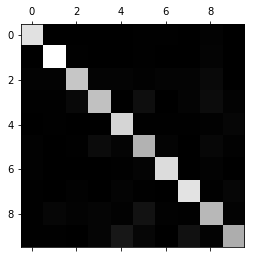

In [176]:
plt.matshow(conf_mx,cmap=plt.cm.gray)

这个混淆矩阵看起来 __相当好__ ， __因为大多数的图片在主对角线上__ 。 __在主对角线上意味着被分类正确__。

数字 5 对应的格子看起来比其他数字要 __暗淡__ 许多。这可能是数据集当中 __数字 5 的图片比较少__ ，又 __或者是分类器对于数字 5 的表现不如其他数字那么好__ 。

你可以验证两种情况。

### 通过混淆矩阵 - 绘制误差数据的图像

让我们现在开始关注 __误差数据的图像__ 呈现。

首先你需要将混淆矩阵中的 __每一个值__ 除以 __相应类别的图片总数__ 。这样子你可以 __比较错误率__ ，而不是绝对错误数 (比较绝对错误数对大的类别不公平)。

In [191]:
row_sums = conf_mx.sum(axis=1,keepdims=True) 
norm_conf_mx_ = conf_mx/row_sums

__现在让我们用	0	来填充对角线。这样子就只保留了被错误分类的数据。__ 让我们画出这个结果。

__因为原来的对角线是TP。__

fill_diagonal 用于 __填充任意维度的给定数组的主对角线__。

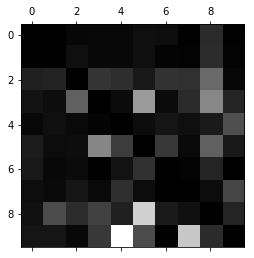

In [193]:
np.fill_diagonal(norm_conf_mx_,0) # 填充矩阵的主对角线。
plt.matshow(norm_conf_mx_,cmap=plt.cm.gray)

现在你可以清楚看出分类器制造出来的各类误差。

__记住：__ 

* __行代表实际类别__ ， __列代表预测的类别__ 。

* __亮__ 表示 __误分__ ， __黑__ 表示 __正确分类__。

    第 8、9 列相当 __亮__ ，这告诉你许多图片被 __误分__ 成数字 8 或者数字 9。相似的，第 8、9 行 也相当 __亮__ ，告诉你数字 8、数字 9 经常被 __误以为__ 是其他数字。

    相反，一些行相当 __黑__ ，比如第一行：这意味着大部分的数字 1 被 __正确分类__ （一些被误分类为数字 8 ）。

留意到误差图不是严格对称的。举例子，比起将数字 8 误分类为数字 5 的数量，有更多的数字 8 被误分类为数字 5。



__分析混淆矩阵通常可以给你提供深刻的见解去改善你的分类器。__

回顾这幅图，看样子你应该 努力改善分类器在数字	8	和数字	9	上的表现，和纠正	3/5	的混淆。举例子，你可以尝试去收 集更多的数据，或者你可以构造新的、有助于分类器的特征。

* 举例子，写一个算法去数闭合的环（比如，数字	8	有两个环，数字	6	有一个， 5 没有）

__错误产生的原因 - 可能和算法复杂度有关 ：__

有时候我们会发现，大部分被误分类的数字，在我们看来都是显而易见的错误。很难明白为什么分类器会分错。 __原因是我们使用的简单的 SGDClassifier ，这是一个线性模型。__

__它所做的全部工作就是分配一个类权重给每一个像素，然后当它看到一张新的图片，它就将加权的像素强度相加，每个类得到一个新的值。__ 所以，因为 3 和 5 只有一小部分的像素有差异，这个模型很容易混淆它们。


### 多标签分类

到目前为止，所有的样例都总是被分配到仅一个类。 __有些情况下，你也许想让你的分类器给 一个样例输出多个类别。__ 

比如说，思考一个人脸识别器。如果对于同一张图片，它识别出几 个人，它应该做什么？当然它应该给每一个它识别出的人贴上一个标签。比方说，这个分类 器被训练成识别三个人脸，Alice，Bob，Charlie；然后当它被输入一张含有	Alice	和	Bob	的 图片，它应该输出	[1,	0,	1]	（意思是：Alice	是，Bob	不是，Charlie	是）。 __这种输出多个二值标签的分类系统被叫做多标签分类系统。__


In [197]:
from sklearn.neighbors import KNeighborsClassifier

In [199]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

这段代码创造了一个 y_multilabel 数组，里面包含两个目标标签。第一个标签指出这个数字是否为大数字（7，8 或者 9），第二个标签指出这个数字是否是奇数。

接下来几行代码会创建一个 KNeighborsClassifier 样例（它支持多标签分类，但不是所有分类器都可以），然后我们使用多目标数组来训练它。现在你可以生成一个预测，然后它 __输出两个标签。__

In [200]:
knn_clf.predict([some_digit])

array([[False,  True]])